In [26]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import FinanceDataReader as fdr

In [27]:
def call_dataset(ticker = 'KR10YT=RR', stt = '2005-01-01', end = '2021-04-30', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values # 값만 갖고온다
    data_normalizer = preprocessing.MinMaxScaler() # 데이터를 0~1 범위로 점철되게 하는 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 데이터를 0~1 범위로 점철되게 함수 수행
    print('data_normalized: ', data_normalized.shape)
     # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) # 1XN 벡터 -> NX1 벡터로

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    # 인풋 X : 그 이전의 OHLCV (from T = -50 to T = -1)
    # 아웃풋 y : 예측하고자 하는 주가 T = 0

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalized:
        # note since we are using his[3] we are taking the SMA of the closing price
        # print('his: ', his)
        # print('his[:, 3]: ', his[:, 3])
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

In [28]:
history_points = 50
ticker = 'KR10YT=RR' 

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
#tensorflow.random.set_seed(44)
#from util import csv_to_dataset, history_points

#dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.0-rc0
data:  (4670, 4)
data_normalized:  (4670, 4)
ohlcv_histories_normalized:  (4620, 50, 4)
ohlcv_histories_normalized.shape[0]:  4620
ohlcv_train.shape:  (3233, 50, 4)
ohlcv_test.shape:  (1386, 50, 4)


In [29]:
ohlcv_train

array([[[0.78998384, 0.7415507 , 0.74103586, 0.74221693],
        [0.78675283, 0.73757455, 0.73705179, 0.73825104],
        [0.78513732, 0.73558648, 0.73505976, 0.73626809],
        ...,
        [0.64781906, 0.56262425, 0.56772908, 0.55978584],
        [0.64135703, 0.56461233, 0.56772908, 0.5578029 ],
        [0.64458805, 0.55666004, 0.56374502, 0.55581995]],

       [[0.78675283, 0.73757455, 0.73705179, 0.73825104],
        [0.78513732, 0.73558648, 0.73505976, 0.73626809],
        [0.7819063 , 0.73161034, 0.7310757 , 0.7323022 ],
        ...,
        [0.64135703, 0.56461233, 0.56772908, 0.5578029 ],
        [0.64458805, 0.55666004, 0.56374502, 0.55581995],
        [0.64297254, 0.55666004, 0.56175299, 0.5578029 ]],

       [[0.78513732, 0.73558648, 0.73505976, 0.73626809],
        [0.7819063 , 0.73161034, 0.7310757 , 0.7323022 ],
        [0.7819063 , 0.73161034, 0.7310757 , 0.7323022 ],
        ...,
        [0.64458805, 0.55666004, 0.56374502, 0.55581995],
        [0.64297254, 0.556660

In [30]:
# model architecture
lstm_input = Input(shape=(history_points, 4), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/50
91/91 [==============================] - 1s 5ms/step - loss: 0.0407 - val_loss: 1.2960e-04
Epoch 2/50
91/91 [==============================] - 0s 4ms/step - loss: 7.8803e-04 - val_loss: 1.3265e-04
Epoch 3/50
91/91 [==============================] - 0s 4ms/step - loss: 7.4668e-04 - val_loss: 1.0395e-04
Epoch 4/50
91/91 [==============================] - 0s 4ms/step - loss: 8.0043e-04 - val_loss: 1.0736e-04
Epoch 5/50
91/91 [==============================] - 0s 5ms/step - loss: 7.6307e-04 - val_loss: 1.3239e-04
Epoch 6/50
91/91 [==============================] - 0s 5ms/step - loss: 7.7761e-04 - val_loss: 1.3259e-04
Epoch 7/50
91/91 [==============================] - 0s 5ms/step - loss: 7.4589e-04 - val_loss: 1.2948e-04
Epoch 8/50
91/91 [==============================] - 0s 4ms/step - loss: 6.7162e-04 - val_loss: 1.1420e-04
Epoch 9/50
91/91 [==============================] - 0s 4ms/step - loss: 6.7371e-04 - val_loss: 1.1969e-04
Epoch 10/50
91/91 [==============================]

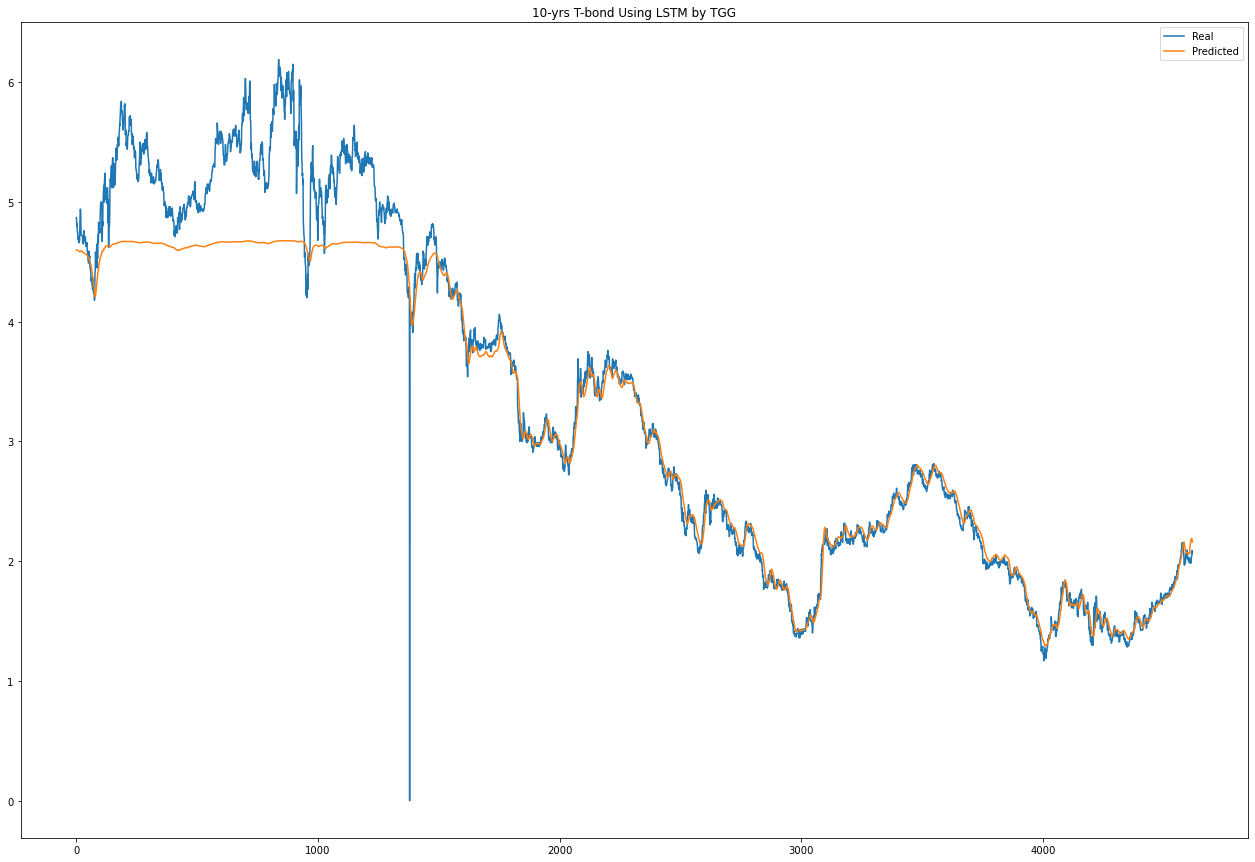

In [31]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('10-yrs T-bond Using LSTM by TGG')
plt.show()

In [32]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [33]:
foo

,real,pred
0,4.870,4.597147
1,4.830,4.598251
2,4.800,4.598642
3,4.820,4.598579
4,4.750,4.598944
...,...,...
4614,2.043,2.189953
4615,2.045,2.190925
4616,2.045,2.184967
4617,2.089,2.173082


In [34]:
foo.corr()

,real,pred
real,1.000000,0.984687
pred,0.984687,1.000000


In [35]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.00000,0.98501
pred,0.98501,1.00000
